# Sentimental Analysis of 1 million tweets by NLP
(Ali Jaan AI23-C2-01)

In [3]:
import nltk
nltk.download('omw-1.4')# to download the Open Multilingual WordNet (OMW) resource using NLTK (Natural Language Toolkit)


[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\UR\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

# Importing all the necessary libraries

In [5]:
import re
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

# Loading the data

In [72]:
columns  = ["sentiment", "ids", "date", "flag", "user", "text"]
encode = "ISO-8859-1"
dataset = pd.read_csv('sentimental data.csv',encoding=encode , names=columns)
dataset = dataset[['sentiment','text']]
dataset['sentiment'] = dataset['sentiment'].replace(4,1)

# Seprating and scaling the data set

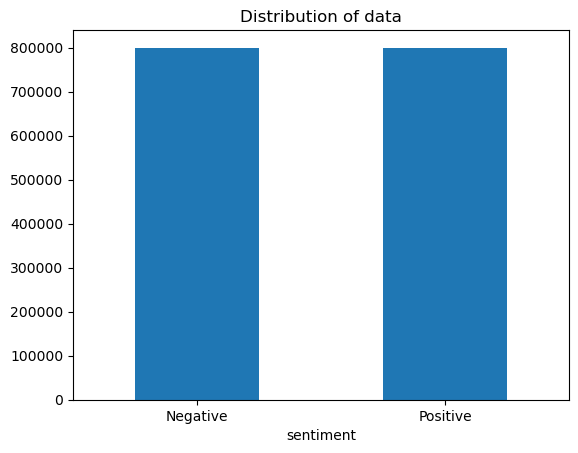

In [73]:
# plotting the dataset
ax = dataset.groupby('sentiment').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)
text, sentiment = list(dataset['text']), list(dataset['sentiment'])

In [74]:
dataset

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."
...,...,...
1599995,1,Just woke up. Having no school is the best fee...
1599996,1,TheWDB.com - Very cool to hear old Walt interv...
1599997,1,Are you ready for your MoJo Makeover? Ask me f...
1599998,1,Happy 38th Birthday to my boo of alll time!!! ...


In [75]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}


In [76]:
# Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [113]:
def preprocess(textdata):
    processedText = []
    
    # Creating Lemmatizer and Stemmer.
    wordLemm = WordNetLemmatizer() #converting words to their base or dictionary form
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)" #to match URLs in the text
    userPattern       = '@[^\s]+' #to identify and potentially remove user mentions from the text
    alphaPattern      = "[^a-zA-Z0-9]" #to remove non-alphanumeric characters from the text.
    sequencePattern   = r"(.)\1\1+" #to identify sequences of repeated characters (3 or more repetitions) in the text
    seqReplacePattern = r"\1\1" #to replace sequences of repeated characters with just two occurrences of the same character.
    
    for tweet in textdata:
        tweet = tweet.lower()
        tweet = re.sub(urlPattern,' URL',tweet)
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
        tweet = re.sub(userPattern,' USER', tweet)
        
        tweet = re.sub(alphaPattern, " ", tweet)
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

        tweetwords = ''
        for word in tweet.split():
            if len(word)>1:
                word = wordLemm.lemmatize(word)
                tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [114]:
processedtext = preprocess(text) # passing the values to the function 

In [115]:
# training the data
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,test_size = 0.2, random_state = 42)

In [116]:
print('No. of values of X_train:')
print(len(X_train))
print('No. of values of X_test:')
print(len(X_test))

No. of values of X_train:
1280000
No. of values of X_test:
320000


In [117]:
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)# converting a collection of text documents into a matrix of TF-IDF features
vectoriser.fit(X_train)
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

Vectoriser fitted.
No. of feature_words:  500000


In [118]:
#Transforming the X_train and X_test dataset into matrix of TF-IDF Features by using the TF-IDF Vectoriser.
X_train = vectoriser.transform(X_train)
print('X_train_transformed:',X_train)
X_test  = vectoriser.transform(X_test)
print('X_test_trandformed:',X_test)
print(f'Data Transformed.')

X_train_transformed:   (0, 492338)	0.19678137676893245
  (0, 491929)	0.11563626454962006
  (0, 489303)	0.2506064824043719
  (0, 489057)	0.1283945320798918
  (0, 481414)	0.2072244813024059
  (0, 478618)	0.07804783158637273
  (0, 452786)	0.18797830932557177
  (0, 446757)	0.03775655028866074
  (0, 433084)	0.28264068449095564
  (0, 402190)	0.17011774100830712
  (0, 400503)	0.07104915113886723
  (0, 380747)	0.17355156787470533
  (0, 380662)	0.12545643510572124
  (0, 345897)	0.23124945401345018
  (0, 345822)	0.12253264692965303
  (0, 340942)	0.21043913640310544
  (0, 339860)	0.10328011768712649
  (0, 333840)	0.2645947309081487
  (0, 333559)	0.17164903634682077
  (0, 318883)	0.20398548450119716
  (0, 318872)	0.18764745621848472
  (0, 296171)	0.08209070289547893
  (0, 280780)	0.24020542771767317
  (0, 280284)	0.05822141305990863
  (0, 243156)	0.28652381285096973
  :	:
  (1279998, 45638)	0.07645912352983125
  (1279998, 3952)	0.26865271413758157
  (1279998, 3935)	0.17752869334261237
  (1279999, 

# Model selection

In [119]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)

LogisticRegression(C=2, max_iter=1000, n_jobs=-1)

# Evaluating the model

In [120]:
def model_Evaluate(model):
    
    # Predicting values for Test dataset
    y_pred = model.predict(X_test)

    # Printing the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Computing and plotting the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.83      0.82      0.82    159494
           1       0.82      0.83      0.83    160506

    accuracy                           0.83    320000
   macro avg       0.83      0.83      0.83    320000
weighted avg       0.83      0.83      0.83    320000



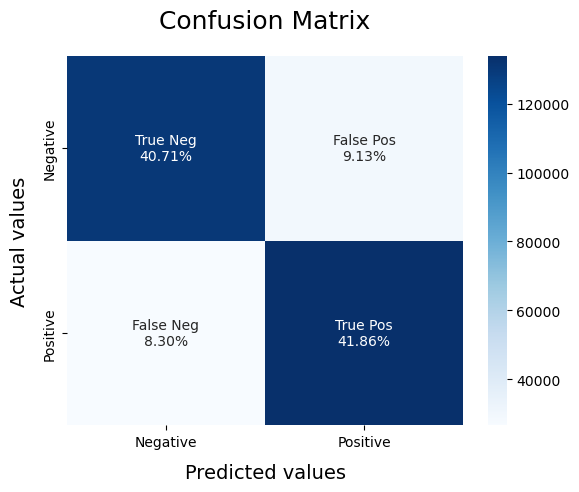

In [121]:
#passing values to the evaluating-function to evaluate the model
model_Evaluate(LRmodel)

# Deployment 

In [122]:
file = open('vectoriser.pickle','wb')
pickle.dump(vectoriser, file)
file.close()
file = open('Sentiment.pickle','wb')
pickle.dump(LRmodel, file)
file.close()